## Application of BPR on Movielens

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%%time
#df = load_movielens_data('ml-1m')
df = load_movielens_data('ml-100k')
dfshort = df[df['rating'] > 0]
df.head()

CPU times: user 16.7 ms, sys: 13.6 ms, total: 30.3 ms
Wall time: 142 ms


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
cf = UserItemInteractions(
    name='MovieLens-100k',
    users=dfshort['user_id'],
    items=dfshort['item_id'],
    min_num_rating_per_user=10,
    min_num_rating_per_item=10,
    num_cores = 1
)
cf.print_memory_usage()
cf.generate_train_test(user_test_ratio=0.2)
bpr = BPR(
    num_features=10,
    reg_lambda=0.,
    num_iters=200,
    learning_rate = 0.5,
    batch_size=5,
    initial_std=0.01,
    seed=None
)
bpr_ndcg_func = partial(
    cf.get_ndcg_metric,
    num_items=10
)
bpr.fit(cf.R_train, bpr_ndcg_func)
ndcg_df = pd.DataFrame(bpr.ndcg_metric)

--- Memory usage for MovieLens-100k:
Sparse User-Item matrix = 0.09 MB
User-Item dataframe df = 1.98 MB
Item dataframe df_item = 0.1 MB
Item dataframe df_user = 0.05 MB
---


BPR:  93%|██████████████████████████████████████████▊   | 186/200 [02:18<00:10,  1.37it/s]/lustre/eaglefs/projects/zazzle/rsandhu/pybpr/pybpr/bpr.py:164: RuntimeWarning: overflow encountered in exp
  sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
/lustre/eaglefs/projects/zazzle/rsandhu/pybpr/pybpr/bpr.py:164: RuntimeWarning: invalid value encountered in divide
  sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
BPR: 100%|██████████████████████████████████████████████| 200/200 [02:26<00:00,  1.36it/s]


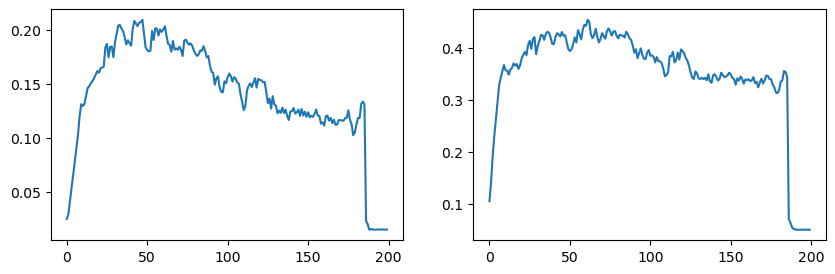

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(ndcg_df['test'])
ax[1].plot(ndcg_df['train'])

In [6]:
bpr_ndcg_func(test=True), bpr_ndcg_func(test=False)

TypeError: UserItemInteractions.get_ndcg_metric() missing 2 required positional arguments: 'user_mat' and 'item_mat'